# Proyek Klasifikasi Gambar: [Intel Image Classification]
- **Nama:** Richelle Vania Thionanda
- **Email:** mc172d5x1392@student.devacademy.id
- **ID Dicoding:** MC172D5X1392

## Import Semua Packages/Library yang Digunakan

In [1]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm as tq

# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
import random
from collections import defaultdict

# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adamax

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [2]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"richellevaniatn","key":"d0a1e81b7e90aea06ab23b2bd5b2d903"}'}

In [3]:
# Download kaggle dataset and unzip file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Coba download
!kaggle datasets download -d puneet6060/intel-image-classification

# Jika download berhasil, unzip
!unzip intel-image-classification.zip


Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [4]:
# Menghapus folder seg_preg karena tidak memiliki label
if os.path.exists('/content/seg_pred'):
    shutil.rmtree('/content/seg_pred')
    print("Folder seg_pred berhasil dihapus.")
else:
    print("Folder seg_pred tidak ditemukan.")

Folder seg_pred berhasil dihapus.


In [5]:
# Direktori awal untuk train dan test
train_dir = 'intel-image-classification/seg_train/seg_train'
test_dir = 'intel-image-classification/seg_test/seg_test'

# Direktori baru untuk dataset gabungan
combined_dir = 'intel-image-classification/dataset'

# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

#### Data Checking

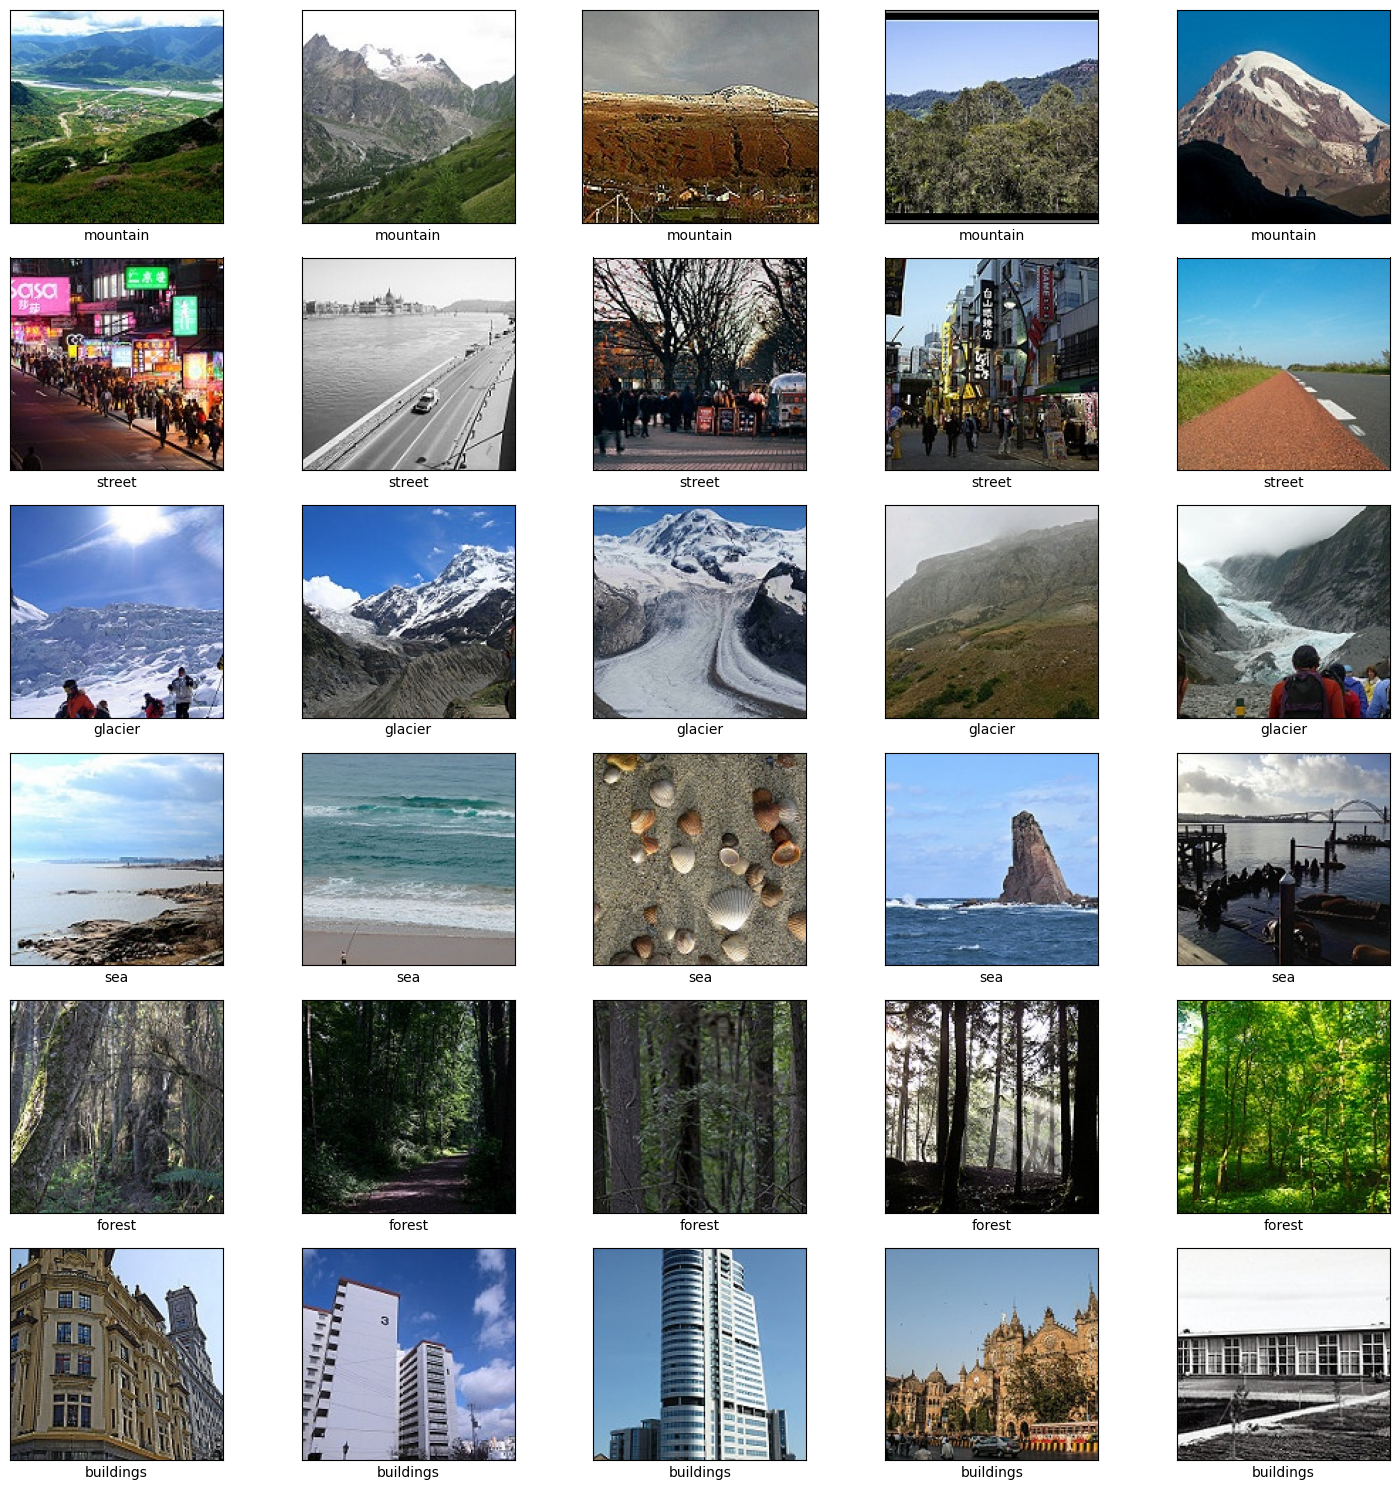

In [7]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
lung_image = {}

# Tentukan path sumber train
path = "intel-image-classification/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    lung_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()
plt.show()

In [18]:
path_sub = "intel-image-classification/dataset"

# Inisialisasi dictionary untuk menyimpan resolusi dan jumlah gambar per kelas
resolutions = {}
class_counts = defaultdict(int)

# Loop melalui setiap kelas dan gambar
for class_name in os.listdir(path_sub):
    class_path = os.path.join(path_sub, class_name)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            try:
                with Image.open(image_path) as img:
                    resolution = img.size
                    if resolution not in resolutions:
                        resolutions[resolution] = 0
                    resolutions[resolution] += 1  # Menghitung jumlah gambar per resolusi
                    class_counts[class_name] += 1
            except Exception as e:
                print(f"Error membuka {image_path}: {e}")

# Menampilkan daftar resolusi dan jumlah gambar untuk setiap resolusi
for res, count in resolutions.items():
    print(f"Resolusi: {res}, Jumlah Gambar: {count}")

# Hitung total jumlah data
total_data = sum(class_counts.values())

# Hitung jumlah ukuran unik
unique_sizes = len(resolutions)

# Tampilkan hasil
print(f"\nTotal Jumlah Data: {total_data}")
print("Total Gambar per Kelas:")
for class_name, count in class_counts.items():
    print(f"- {class_name}: {count}")
print(f"Jumlah Ukuran Unik: {unique_sizes}")

Resolusi: (150, 150), Jumlah Gambar: 16979
Resolusi: (150, 134), Jumlah Gambar: 2
Resolusi: (150, 123), Jumlah Gambar: 2
Resolusi: (150, 144), Jumlah Gambar: 2
Resolusi: (150, 131), Jumlah Gambar: 2
Resolusi: (150, 141), Jumlah Gambar: 2
Resolusi: (150, 147), Jumlah Gambar: 1
Resolusi: (150, 103), Jumlah Gambar: 1
Resolusi: (150, 136), Jumlah Gambar: 2
Resolusi: (150, 146), Jumlah Gambar: 2
Resolusi: (150, 81), Jumlah Gambar: 2
Resolusi: (150, 135), Jumlah Gambar: 3
Resolusi: (150, 143), Jumlah Gambar: 2
Resolusi: (150, 145), Jumlah Gambar: 1
Resolusi: (150, 113), Jumlah Gambar: 7
Resolusi: (150, 100), Jumlah Gambar: 1
Resolusi: (150, 142), Jumlah Gambar: 2
Resolusi: (150, 105), Jumlah Gambar: 1
Resolusi: (150, 119), Jumlah Gambar: 1
Resolusi: (150, 76), Jumlah Gambar: 2
Resolusi: (150, 111), Jumlah Gambar: 3
Resolusi: (150, 97), Jumlah Gambar: 1
Resolusi: (150, 110), Jumlah Gambar: 2
Resolusi: (150, 102), Jumlah Gambar: 1
Resolusi: (150, 72), Jumlah Gambar: 1
Resolusi: (150, 149), Jum

#### Plot Distribusi

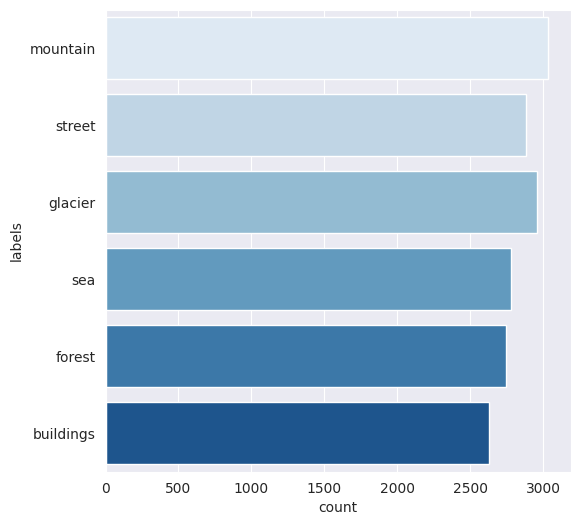

In [19]:
# Definisikan path sumber
lung_path = "intel-image-classification/dataset"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label, palette="Blues")

#### Data Augmentation

In [20]:
# Fungsi-fungsi transformasi (pastikan fungsi-fungsi ini terdefinisi)
def anticlockwise_rotation(img):
    angle = random.randint(10, 90)
    h, w = img.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_img = cv2.warpAffine(img, rotation_matrix, (w, h), borderMode=cv2.BORDER_REFLECT)
    return rotated_img

def clockwise_rotation(img):
    angle = random.randint(10, 90)
    h, w = img.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, -angle, 1.0)
    rotated_img = cv2.warpAffine(img, rotation_matrix, (w, h), borderMode=cv2.BORDER_REFLECT)
    return rotated_img

def warp_shift(img):
    h, w = img.shape[:2]
    tx = random.randint(-20, 20)
    ty = random.randint(-20, 20)
    transform = AffineTransform(translation=(tx, ty))
    warp_image = warp(img, transform, mode="wrap", preserve_range=True)
    return (warp_image * 255).astype(np.uint8)

def blur_image(img):
    blur_amount = random.randint(1, 5) * 2 + 1  # Ukuran kernel ganjil
    blurred_img = cv2.GaussianBlur(img, (blur_amount, blur_amount), 0)
    return blurred_img

def add_brightness(img):
    brightness_factor = 1.0 + random.uniform(-0.3, 0.3)
    img_bright = np.clip((img * brightness_factor), 0, 255).astype(np.uint8)
    return img_bright

def flip_up_down(img):
    flipped_img = cv2.flip(img, 0)
    return flipped_img

def sheared(img):
    shear_factor = random.uniform(-0.2, 0.2)
    transform = AffineTransform(shear=shear_factor)
    sheared_image = warp(img, transform, mode="wrap", preserve_range=True)
    return (sheared_image * 255).astype(np.uint8)

In [21]:
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

dataset_path = "intel-image-classification/dataset"  # Path ke folder dataset utama
augmented_dataset_path = "intel-image-classification/augmented_dataset"  # Path untuk menyimpan dataset augmentasi
images_to_generate_per_category = 1000  # Jumlah gambar augmentasi per kategori

if not os.path.exists(augmented_dataset_path):
    os.makedirs(augmented_dataset_path)

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):
        augmented_category_path = os.path.join(augmented_dataset_path, category)
        if not os.path.exists(augmented_category_path):
            os.makedirs(augmented_category_path)

        images = []
        for im in os.listdir(category_path):
            img_path = os.path.join(category_path, im)
            if os.path.isfile(img_path):  # Hanya memproses file
                images.append(img_path)

        print(f"Augmenting category: {category} with {images_to_generate_per_category} images.")
        i = 0
        while i < images_to_generate_per_category and images:
            image_path = random.choice(images)
            try:
                original_image = io.imread(image_path)

                if original_image.ndim not in [3, 4]:
                    raise ValueError(f'Invalid image dimensions for {image_path}')

                transformed_image = None
                n = 0
                transformation_count = random.randint(1, len(transformations))

                temp_image = original_image.copy()
                while n < transformation_count:
                    key = random.choice(list(transformations))
                    temp_image = transformations[key](temp_image)
                    n += 1
                transformed_image = temp_image

                new_image_name = f"augmented_{os.path.splitext(os.path.basename(image_path))[0]}_{i+1}.jpg"
                new_image_path = os.path.join(augmented_category_path, new_image_name)
                transformed_image = img_as_ubyte(transformed_image)
                cv2.imwrite(new_image_path, transformed_image)
                i += 1

            except ValueError as e:
                print(f'Could not read or process the image {image_path}: {e}, hence skipping it.')
            except Exception as e:
                print(f'An error occurred during augmentation of {image_path}: {e}')
        print(f"Finished augmenting category: {category}. Generated {i} images.")

print("Augmentation process complete for all categories.")

Augmenting category: mountain with 1000 images.
Finished augmenting category: mountain. Generated 1000 images.
Augmenting category: street with 1000 images.
Finished augmenting category: street. Generated 1000 images.
Augmenting category: glacier with 1000 images.
Finished augmenting category: glacier. Generated 1000 images.
Augmenting category: sea with 1000 images.
Finished augmenting category: sea. Generated 1000 images.
Augmenting category: forest with 1000 images.
Finished augmenting category: forest. Generated 1000 images.
Augmenting category: buildings with 1000 images.
Finished augmenting category: buildings. Generated 1000 images.
Augmentation process complete for all categories.


In [22]:
def count_images(path):
    counts = defaultdict(int)
    for category in os.listdir(path):
        category_path = os.path.join(path, category)
        if os.path.isdir(category_path):
            counts[category] = len([f for f in os.listdir(category_path) if f.endswith(('.jpg', '.png'))])
    return counts

print("Original dataset:")
print(count_images(dataset_path))
print("\nAugmented dataset:")
print(count_images(augmented_dataset_path))

Original dataset:
defaultdict(<class 'int'>, {'mountain': 3037, 'street': 2883, 'glacier': 2957, 'sea': 2784, 'forest': 2745, 'buildings': 2628})

Augmented dataset:
defaultdict(<class 'int'>, {'mountain': 1000, 'street': 1000, 'glacier': 1000, 'sea': 1000, 'forest': 1000, 'buildings': 1000})


Distribution of images across classes:
labels
mountain     3037
glacier      2957
street       2883
sea          2784
forest       2745
buildings    2628
Name: count, dtype: int64


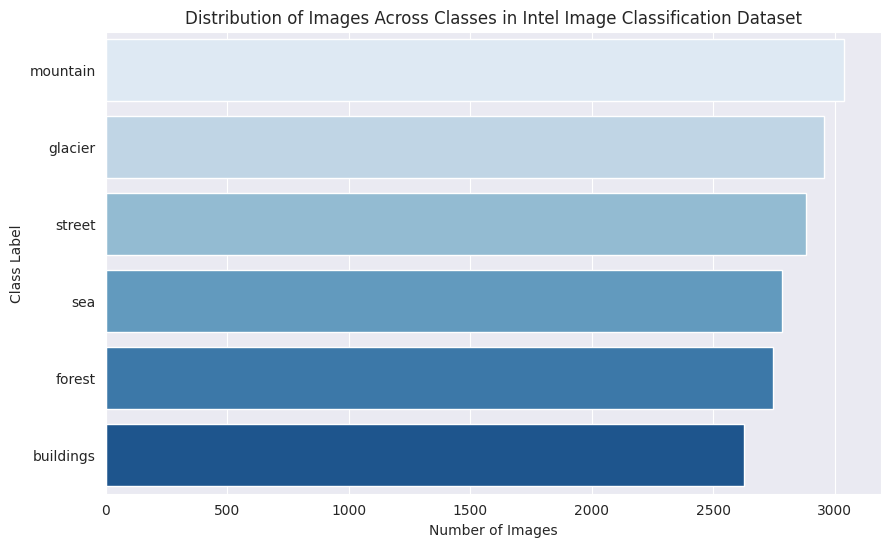

In [23]:
# Define source path to the dataset
lung_path = "intel-image-classification/dataset/"

# Create lists to store data
file_name = []
labels = []
full_path = []

# Walk through the directory structure to get file paths and labels
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        if name.endswith(('.jpg', '.jpeg', '.png')):  # Filter for image files
            full_path.append(os.path.join(path, name))
            labels.append(path.split('/')[-1])
            file_name.append(name)

# Create a Pandas DataFrame to store the data
distribution_train = pd.DataFrame({"path": full_path, "file_name": file_name, "labels": labels})

# Print the distribution of images per class
print("Distribution of images across classes:")
print(distribution_train['labels'].value_counts())

# Plot the distribution of images across the classes
plt.figure(figsize=(10, 6))  # Adjust figure size for better readability
sns.set_style("darkgrid")
plot_data = sns.countplot(data=distribution_train, y='labels', order=distribution_train['labels'].value_counts().index, palette="Blues")
plt.title('Distribution of Images Across Classes in Intel Image Classification Dataset')
plt.xlabel('Number of Images')
plt.ylabel('Class Label')
plt.show()

### Data Preprocessing

#### Split Dataset

In [24]:
# Path ke folder dataset utama Intel Image Classification
dataset_path = "intel-image-classification/dataset"
# Path ke folder tujuan untuk data final yang telah di-split
output_path = "data_final"

# Rasio pembagian data
train_ratio = 0.8
test_ratio = 0.1
val_ratio = 0.1

# Pastikan folder output utama ada
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Buat folder train, test, dan val di dalam folder output
train_dir = os.path.join(output_path, "train")
test_dir = os.path.join(output_path, "test")
val_dir = os.path.join(output_path, "val")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Loop melalui setiap kategori di dalam dataset utama
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):
        print(f"Processing category: {category}")

        # Dapatkan list semua file gambar dalam kategori
        all_images = [os.path.join(category_path, f) for f in os.listdir(category_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

        # Split data menjadi train dan sementara (test + val)
        train_images, temp_images = train_test_split(all_images, test_size=(test_ratio + val_ratio), random_state=42)

        # Split data sementara menjadi test dan val
        test_images, val_images = train_test_split(temp_images, test_size=val_ratio / (test_ratio + val_ratio), random_state=42)

        # Buat folder kategori di dalam folder train, test, dan val jika belum ada
        train_category_dir = os.path.join(train_dir, category)
        test_category_dir = os.path.join(test_dir, category)
        val_category_dir = os.path.join(val_dir, category)

        os.makedirs(train_category_dir, exist_ok=True)
        os.makedirs(test_category_dir, exist_ok=True)
        os.makedirs(val_category_dir, exist_ok=True)

        # Salin file gambar ke folder train
        for img_path in train_images:
            shutil.copy(img_path, os.path.join(train_category_dir, os.path.basename(img_path)))
        print(f"  Moved {len(train_images)} images to train")

        # Salin file gambar ke folder test
        for img_path in test_images:
            shutil.copy(img_path, os.path.join(test_category_dir, os.path.basename(img_path)))
        print(f"  Moved {len(test_images)} images to test")

        # Salin file gambar ke folder val
        for img_path in val_images:
            shutil.copy(img_path, os.path.join(val_category_dir, os.path.basename(img_path)))
        print(f"  Moved {len(val_images)} images to val")

print("Data splitting process complete. Data is organized in 'data_final' folder.")

Processing category: mountain
  Moved 2429 images to train
  Moved 304 images to test
  Moved 304 images to val
Processing category: street
  Moved 2306 images to train
  Moved 288 images to test
  Moved 289 images to val
Processing category: glacier
  Moved 2365 images to train
  Moved 296 images to test
  Moved 296 images to val
Processing category: sea
  Moved 2227 images to train
  Moved 278 images to test
  Moved 279 images to val
Processing category: forest
  Moved 2196 images to train
  Moved 274 images to test
  Moved 275 images to val
Processing category: buildings
  Moved 2102 images to train
  Moved 263 images to test
  Moved 263 images to val
Data splitting process complete. Data is organized in 'data_final' folder.


#### Image Data Generator

In [25]:
# Define training, testing, and validation directories
TRAIN_DIR = "data_final/train/"
TEST_DIR = "data_final/test/"
VAL_DIR = "data_final/val/"

# Dapatkan daftar nama kelas (nama subdirektori) di dalam direktori training
train_class_names = [d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))]
train_class_names.sort()  # Urutkan nama kelas untuk konsistensi

# Dapatkan daftar nama kelas di dalam direktori testing
test_class_names = [d for d in os.listdir(TEST_DIR) if os.path.isdir(os.path.join(TEST_DIR, d))]
test_class_names.sort()  # Urutkan nama kelas untuk konsistensi

# Dapatkan daftar nama kelas di dalam direktori validation
val_class_names = [d for d in os.listdir(VAL_DIR) if os.path.isdir(os.path.join(VAL_DIR, d))]
val_class_names.sort()  # Urutkan nama kelas untuk konsistensi

print("Distribution of images in training set:")
for class_name in train_class_names:
    train_class_path = os.path.join(TRAIN_DIR, class_name)
    num_train_images = len([f for f in os.listdir(train_class_path) if os.path.isfile(os.path.join(train_class_path, f)) and f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    print(f"Total number of {class_name} images in training set: {num_train_images}")

print("\nDistribution of images in test set:")
for class_name in test_class_names:
    test_class_path = os.path.join(TEST_DIR, class_name)
    num_test_images = len([f for f in os.listdir(test_class_path) if os.path.isfile(os.path.join(test_class_path, f)) and f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    print(f"Total number of {class_name} images in test set: {num_test_images}")

print("\nDistribution of images in validation set:")
for class_name in val_class_names:
    val_class_path = os.path.join(VAL_DIR, class_name)
    num_val_images = len([f for f in os.listdir(val_class_path) if os.path.isfile(os.path.join(val_class_path, f)) and f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    print(f"Total number of {class_name} images in validation set: {num_val_images}")

Distribution of images in training set:
Total number of buildings images in training set: 2102
Total number of forest images in training set: 2196
Total number of glacier images in training set: 2365
Total number of mountain images in training set: 2429
Total number of sea images in training set: 2227
Total number of street images in training set: 2306

Distribution of images in test set:
Total number of buildings images in test set: 263
Total number of forest images in test set: 274
Total number of glacier images in test set: 296
Total number of mountain images in test set: 304
Total number of sea images in test set: 278
Total number of street images in test set: 288

Distribution of images in validation set:
Total number of buildings images in validation set: 263
Total number of forest images in validation set: 275
Total number of glacier images in validation set: 296
Total number of mountain images in validation set: 304
Total number of sea images in validation set: 279
Total number

In [26]:
# Image dimensions
img_height = 224
img_width = 224
batch_size = 32
color_mode = "rgb"
class_mode = 'categorical'

# Create ImageDataGenerator objects with normalization
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for training
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode=color_mode,
    class_mode=class_mode,
    shuffle=True
)

# Create data generator for testing
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(img_height, img_width),
    batch_size=batch_size, # Or 1 for more precise individual predictions
    color_mode=color_mode,
    class_mode=class_mode,
    shuffle=False  # No need to shuffle test data
)

# Create data generator for validation
validation_generator = validation_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode=color_mode,
    class_mode=class_mode,
    shuffle=False # No need to shuffle validation data
)

# Print information to verify the setup
print("Training data generator created.")
print("Found", train_generator.samples, "images belonging to", train_generator.num_classes, "classes in the training set.")
print("Classes:", train_generator.class_indices)

print("\nTesting data generator created.")
print("Found", test_generator.samples, "images belonging to", test_generator.num_classes, "classes in the test set.")
print("Classes:", test_generator.class_indices)

print("\nValidation data generator created.")
print("Found", validation_generator.samples, "images belonging to", validation_generator.num_classes, "classes in the validation set.")
print("Classes:", validation_generator.class_indices)

Found 13625 images belonging to 6 classes.
Found 1703 images belonging to 6 classes.
Found 1706 images belonging to 6 classes.
Training data generator created.
Found 13625 images belonging to 6 classes in the training set.
Classes: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}

Testing data generator created.
Found 1703 images belonging to 6 classes in the test set.
Classes: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}

Validation data generator created.
Found 1706 images belonging to 6 classes in the validation set.
Classes: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


## Modelling

In [27]:
model = Sequential([
    Conv2D(64, kernel_size= (3,3),padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
    Conv2D(64, kernel_size= (3,3),padding='same', activation='relu'),

    MaxPooling2D((2,2)),

    Conv2D(128, kernel_size= (3,3),padding='same', activation='relu'),
    Conv2D(128, kernel_size= (3,3),padding='same', activation='relu'),

    MaxPooling2D((2,2)),


    Conv2D(128, kernel_size= (3,3),padding='same', activation='relu'),
    Conv2D(128, kernel_size= (3,3),padding='same', activation='relu'),

    MaxPooling2D((2,2)),

    Conv2D(256, kernel_size= (3,3),padding='same', activation='relu'),
    Conv2D(256, kernel_size= (3,3),padding='same', activation='relu'),

    MaxPooling2D((2,2)),

    Conv2D(512, kernel_size= (3,3),padding='same', activation='relu'),
    Conv2D(512, kernel_size= (3,3),padding='same', activation='relu'),

    MaxPooling2D((2,2)),

    Conv2D(512, kernel_size= (3,3),padding='same', activation='relu'),
    Conv2D(512, kernel_size= (3,3),padding='same', activation='relu'),

    MaxPooling2D((2,2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax') ])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 7, 7, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 7, 7, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,896,902 (41.57 MB)

 Trainable params: 10,896,902 (41.57 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [30]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


426/426 ━━━━━━━━━━━━━━━━━━━━ 189s 379ms/step - accuracy: 0.3751 - loss: 1.4602 - val_accuracy: 0.6413 - val_loss: 0.8854
Epoch 2/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 130s 306ms/step - accuracy: 0.6284 - loss: 0.9436 - val_accuracy: 0.7110 - val_loss: 0.7749
Epoch 3/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 129s 304ms/step - accuracy: 0.7185 - loss: 0.7653 - val_accuracy: 0.7702 - val_loss: 0.6129
Epoch 4/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 131s 307ms/step - accuracy: 0.7568 - loss: 0.6585 - val_accuracy: 0.7902 - val_loss: 0.5669
Epoch 5/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 130s 306ms/step - accuracy: 0.8033 - loss: 0.5685 - val_accuracy: 0.8376 - val_loss: 0.4797
Epoch 6/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 142s 305ms/step - accuracy: 0.8323 - loss: 0.4880 - val_accuracy: 0.8505 - val_loss: 0.4390
Epoch 7/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 129s 303ms/step - accuracy: 0.8548 - loss: 0.4316 - val_accuracy: 0.8564 - val_loss: 0.4451
Epoch 8/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 129s 303ms/step - accuracy: 0.8646 - loss: 0.40

## Evaluasi dan Visualisasi

In [31]:
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy * 100:.2f}%')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.8695 - loss: 0.4260
Test accuracy: 85.09%


In [32]:
loss, accuracy = model.evaluate(train_generator)
print(f'Train accuracy: {accuracy * 100:.2f}%')

426/426 ━━━━━━━━━━━━━━━━━━━━ 50s 117ms/step - accuracy: 0.9178 - loss: 0.2313
Train accuracy: 92.16%


In [33]:
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation accuracy: {accuracy * 100:.2f}%')

54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.8678 - loss: 0.3710
Validation accuracy: 86.87%


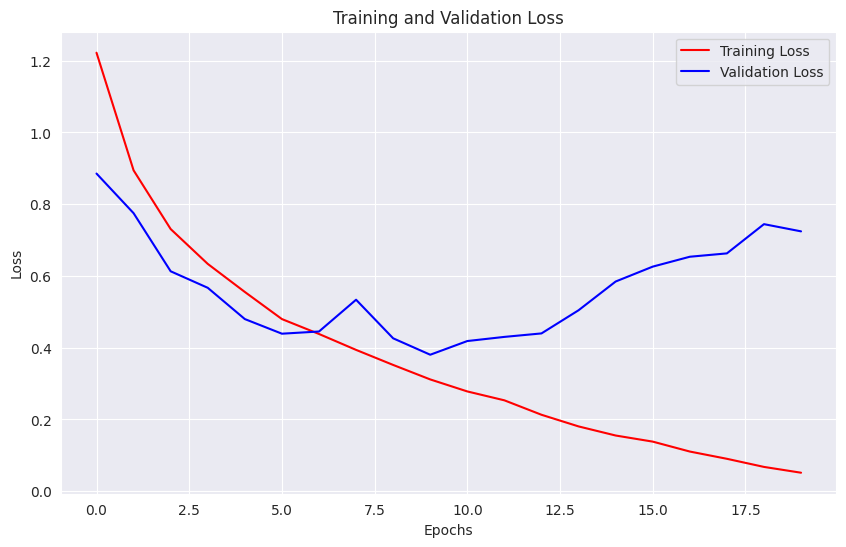

In [34]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, c="red", label="Training Loss")
plt.plot(epochs, val_loss, c="blue", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

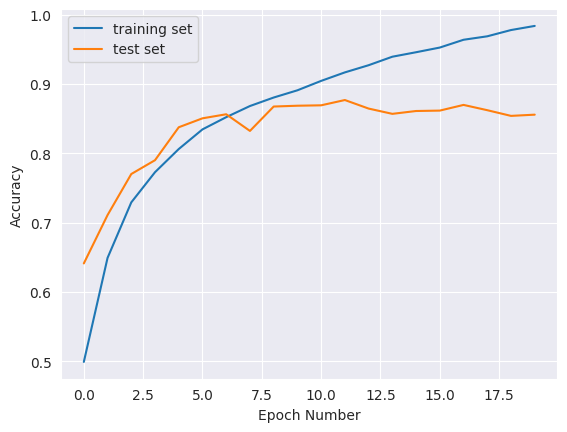

In [35]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='test set')
plt.legend()

In [36]:
# Hitung selisih antara akurasi training dan validation
train_accuracy = history.history['accuracy'][-1] # Ambil akurasi training terakhir
val_accuracy = history.history['val_accuracy'][-1] # Ambil akurasi validation terakhir
accuracy_diff = train_accuracy - val_accuracy

# Tentukan ambang batas untuk overfitting
overfitting_threshold = 0.1

# Cetak skor, akurasi akhir, dan kesimpulan
print(f"Akurasi Training: {train_accuracy:.4f}")
print(f"Akurasi Validation: {val_accuracy:.4f}")
print(f"Selisih Akurasi: {accuracy_diff:.4f}")

Akurasi Training: 0.9838
Akurasi Validation: 0.8558
Selisih Akurasi: 0.1280


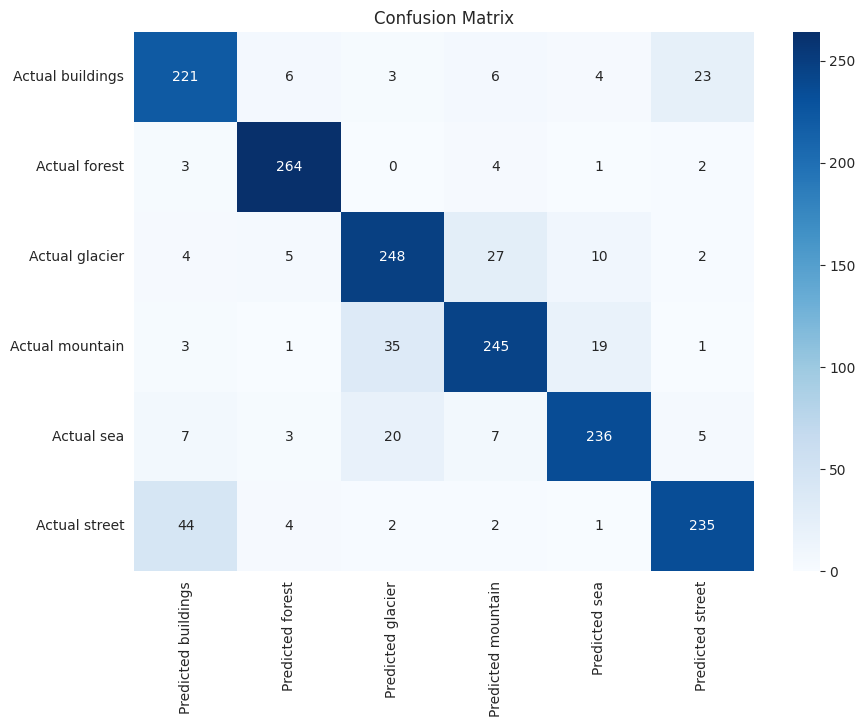


Classification Report:

              precision    recall  f1-score   support

   buildings     0.7837    0.8403    0.8110       263
      forest     0.9329    0.9635    0.9479       274
     glacier     0.8052    0.8378    0.8212       296
    mountain     0.8419    0.8059    0.8235       304
         sea     0.8708    0.8489    0.8597       278
      street     0.8769    0.8160    0.8453       288

    accuracy                         0.8509      1703
   macro avg     0.8519    0.8521    0.8515      1703
weighted avg     0.8518    0.8509    0.8508      1703



In [37]:
# Reset generator
test_generator.reset()

# Prediksi
preds = model.predict(test_generator, verbose=0)

# Ambil prediksi kelas (bukan probabilitas)
pred_classes = np.argmax(preds, axis=1)

# Ambil label asli
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = pd.DataFrame(
    confusion_matrix(true_classes, pred_classes),
    index=[f"Actual {label}" for label in class_labels],
    columns=[f"Predicted {label}" for label in class_labels]
)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(true_classes, pred_classes, target_names=class_labels, digits=4))

#### Analisis Deskriptif Performa Training Model
Berikut adalah rangkuman dan interpretasi hasil dari proses pelatihan model klasifikasi:

**1. Akurasi pada Data Training dan Validasi**
- Perkembangan Umum: Terlihat adanya tren peningkatan akurasi yang signifikan di awal fase training, baik pada dataset training maupun validasi. Setelah melewati beberapa iterasi (epoch), laju peningkatan akurasi cenderung melambat dan mencapai kondisi yang relatif stabil.

- Nilai Akurasi Awal:
  - Epoch ke-2:
    - Training Accuracy: 0.3751
    - Validation Accuracy: 0.6413

- Pencapaian Akurasi Tertinggi (Epoch ke-20):
    - Training Accuracy: 0.9878
    - Validation Accuracy: 0.8558

- Stabilitas Akhir:
  - Akurasi training sangat tinggi dan stabil dari epoch 16 ke atas (>0.96).
  - Akurasi validasi relatif stabil namun lebih rendah dari training, berkisar di 0.85–0.86.

- Komparasi Akurasi: Terdapat selisih akurasi sebesar 0.1280 antara training dan validation yang menunjukkan indikasi overfitting ringan.

**2. Evaluasi Loss pada Data Training dan Validasi**
- Perkembangan Umum:
  - Loss pada data training turun tajam dari awal (1.4602) ke akhir training (0.0406).
  - Loss validasi sempat menurun hingga sekitar epoch 10 (val_loss minimum: 0.3803), lalu naik kembali.

- Loss Awal:
  - Training Loss (epoch 2): 1.4602
  - Validation Loss (epoch 2): 0.8854

- Loss Terendah:
  - Training Loss (epoch 20): 0.0406
  - Validation Loss (terendah pada epoch 10): 0.3803
  - Validation Loss pada akhir training (epoch 20): meningkat menjadi 0.7243

- Komparasi Loss: Perbedaan mencolok antara training dan validation loss di akhir training menunjukkan overfitting. Model terlalu fokus pada data training dan mulai kehilangan generalisasi.

**3. Evaluasi Model (Setelah Training)**
- Hasil Evaluasi Akhir:
  - Training Accuracy: 92.16%
  - Validation Accuracy: 86.87%
  - Test Accuracy: 85.09%

- Selisih Akurasi (training vs. validation): 0.1280
→ Indikasi overfitting, namun masih dalam batas yang dapat ditoleransi.


**4. Classification Report (Test Data)**
- Rata-rata:
  - Accuracy: 85.09%
  - Macro Avg F1-score: 0.8515
  - Weighted Avg F1-score: 0.8508

- Kinerja Kategori:
  - Precision & recall tertinggi pada kelas forest dan sea
  - Kinerja terendah pada kelas buildings (precision: 0.7837)

**5. Kesimpulan dan Rekomendasi**
- Performa model cukup baik, dengan akurasi >85% pada data validasi dan testing.
- Overfitting ringan terdeteksi, terlihat dari selisih akurasi dan tren loss.
- Memerlukan evaluasi ulang arsitektur model untuk memastikan tidak terlalu kompleks.



## Konversi Model

In [39]:
export_dir = 'submission'
if not os.path.exists(export_dir):
    os.makedirs(export_dir)

try:
    # TFJS
    tfjs_path = os.path.join(export_dir, 'tfjs_model')
    if not os.path.exists(tfjs_path):
        os.makedirs(tfjs_path)
    import tensorflowjs as tfjs
    tfjs.converters.save_keras_model(model, tfjs_path)
    print(f"Model TFJS disimpan di: {tfjs_path}")

    # TFLite
    tflite_path = os.path.join(export_dir, 'tflite')
    if not os.path.exists(tflite_path):
        os.makedirs(tflite_path)
    tflite_model_file = os.path.join(tflite_path, 'model.tflite')
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()
    with open(tflite_model_file, 'wb') as f:
        f.write(tflite_model)
    print(f"Model TFLite disimpan di: {tflite_model_file}")
    # (Jangan lupa menyimpan label jika ada)

    # SavedModel
    saved_model_path = os.path.join(export_dir, 'saved_model')
    tf.saved_model.save(model, saved_model_path)
    print(f"Model SavedModel disimpan di: {saved_model_path}")

    # Atau, jika Anda ingin menggunakan format .keras:
    keras_model_path = os.path.join(export_dir, 'model_klasifikasi.keras')
    keras.saving.save_model(model, keras_model_path)
    print(f"Model Keras disimpan di: {keras_model_path}")

except Exception as e:
    print(f"\nERROR saat menyimpan/konversi model: {e}")
    import traceback
    traceback.print_exc()

failed to lookup keras version from the file,
    this is likely a weight only file
Model TFJS disimpan di: submission/tfjs_model
Saved artifact at '/tmp/tmp8f95whjc'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  136477448426832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136477448427600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136477448427216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136477448427024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136477448429904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136477448430864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136477448429328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136477448431824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136477448431632: TensorS

## Inference (Optional)

Created label file at: submission/tflite/label.txt
Prediksi TFLite: street (98.97%)
Prediksi SavedModel: street (98.95%)


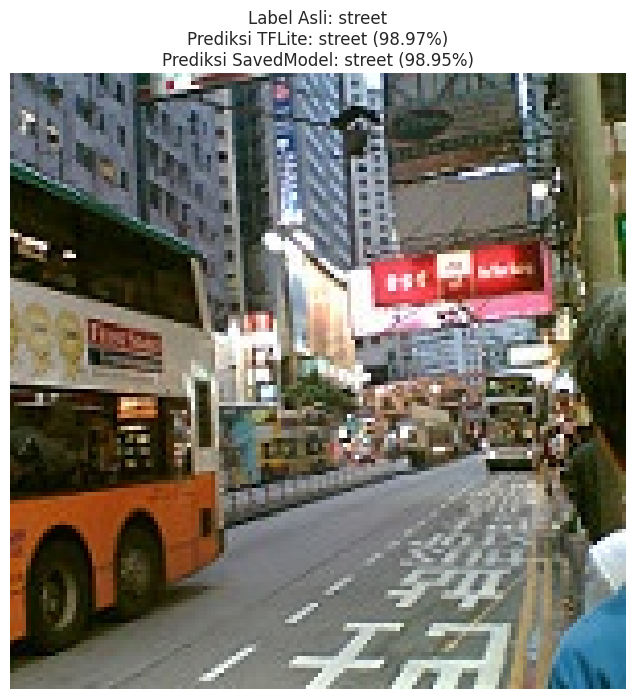


--- HASIL INFERENCE ---
Gambar: 22686.jpg
Label Asli: street
Prediksi Model TFLite: street (98.97%)
Prediksi Model SavedModel: street (98.95%)
-----------------------
Inference completed successfully.


In [40]:
# Define paths and parameters
test_dir = 'data_final/test'
tflite_model_path = 'submission/tflite/model.tflite'
saved_model_path = 'submission/saved_model'
label_file_path = 'submission/tflite/label.txt'
img_height, img_width = 224, 224

# Assume label_map is defined
label_map = {
    'buildings': 0,
    'forest': 1,
    'glacier': 2,
    'mountain': 3,
    'sea': 4,
    'street': 5
}
idx_to_label = {v: k for k, v in label_map.items()}

try:
    # Create label.txt for TFLite if it doesn't exist
    if not os.path.exists(label_file_path):
        os.makedirs(os.path.dirname(label_file_path), exist_ok=True)
        with open(label_file_path, 'w') as f:
            for label in label_map.keys():
                f.write(f"{label}\n")
        print(f"Created label file at: {label_file_path}")

    # Collect test image paths and labels
    test_image_paths = []
    test_labels = []
    for category in os.listdir(test_dir):
        category_path = os.path.join(test_dir, category)
        if os.path.isdir(category_path):
            for img_name in os.listdir(category_path):
                img_path = os.path.join(category_path, img_name)
                test_image_paths.append(img_path)
                test_labels.append(category)

    # Create a DataFrame for test images
    test_category_dir = pd.DataFrame({
        'path': test_image_paths,
        'label': test_labels
    })

    # Select a random image from the test set
    test_image = test_category_dir.sample(n=1).iloc[0]
    test_image_path = test_image['path']
    true_label_name = test_image['label']

    # Preprocess the image
    img = Image.open(test_image_path).resize((img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array.astype('float32') / 255.0

    # 1. Inference with TFLite
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    interpreter.set_tensor(input_details[0]['index'], img_array)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_index_tflite = np.argmax(output_data[0])

    # Load labels for TFLite
    with open(label_file_path, 'r') as f:
        labels = f.read().splitlines()
    predicted_label_tflite = labels[predicted_index_tflite]
    confidence_tflite = np.max(output_data[0]) * 100

    print(f"Prediksi TFLite: {predicted_label_tflite} ({confidence_tflite:.2f}%)")

    # 2. Inference with SavedModel
    saved_model = tf.saved_model.load(saved_model_path)
    infer = saved_model.signatures['serving_default']
    predictions_saved_model = infer(tf.constant(img_array))

    # Extract the output tensor (assuming the output key is 'dense_1' based on typical Keras models)
    output_tensor = predictions_saved_model[list(predictions_saved_model.keys())[0]]
    predicted_index_saved_model = np.argmax(output_tensor.numpy()[0])
    predicted_label_saved_model = idx_to_label[predicted_index_saved_model]
    confidence_saved_model = np.max(output_tensor.numpy()[0]) * 100

    print(f"Prediksi SavedModel: {predicted_label_saved_model} ({confidence_saved_model:.2f}%)")

    # Display the image and predictions
    plt.figure(figsize=(8, 8))
    img_display = Image.open(test_image_path)
    plt.imshow(img_display)
    plt.title(f"Label Asli: {true_label_name}\n"
              f"Prediksi TFLite: {predicted_label_tflite} ({confidence_tflite:.2f}%)\n"
              f"Prediksi SavedModel: {predicted_label_saved_model} ({confidence_saved_model:.2f}%)")
    plt.axis('off')
    plt.show()

    # Print inference results
    print("\n--- HASIL INFERENCE ---")
    print(f"Gambar: {os.path.basename(test_image_path)}")
    print(f"Label Asli: {true_label_name}")
    print(f"Prediksi Model TFLite: {predicted_label_tflite} ({confidence_tflite:.2f}%)")
    print(f"Prediksi Model SavedModel: {predicted_label_saved_model} ({confidence_saved_model:.2f}%)")
    print("-----------------------")
    print("Inference completed successfully.")

except Exception as e:
    print(f"\nERROR saat melakukan inference: {e}")
    import traceback
    traceback.print_exc()

## Requirement.txt & Download Folder dari GCollab

In [41]:
# Tentukan path ke file requirements.txt di dalam folder submission
requirements_path = 'submission/requirements.txt'

# Jalankan pip freeze dan simpan hasilnya ke requirements.txt
# Perintah ini akan membuat file requirements.txt jika belum ada
# dan akan meng-append (menambahkan) output pip freeze ke file yang ada
with open(requirements_path, 'w') as f:
    !pip freeze >> {requirements_path}

print(f"requirements.txt berhasil dibuat di: {requirements_path}")

requirements.txt berhasil dibuat di: submission/requirements.txt


In [42]:
from google.colab import files

!zip -r /content/submission.zip /content/submission
files.download('/content/submission.zip')

  adding: content/submission/ (stored 0%)
  adding: content/submission/tfjs_model/ (stored 0%)
  adding: content/submission/tfjs_model/group1-shard8of11.bin (deflated 8%)
  adding: content/submission/tfjs_model/group1-shard3of11.bin (deflated 8%)
  adding: content/submission/tfjs_model/group1-shard10of11.bin (deflated 8%)
  adding: content/submission/tfjs_model/group1-shard1of11.bin (deflated 8%)
  adding: content/submission/tfjs_model/group1-shard4of11.bin (deflated 8%)
  adding: content/submission/tfjs_model/group1-shard11of11.bin (deflated 8%)
  adding: content/submission/tfjs_model/group1-shard7of11.bin (deflated 8%)
  adding: content/submission/tfjs_model/group1-shard5of11.bin (deflated 8%)
  adding: content/submission/tfjs_model/group1-shard2of11.bin (deflated 8%)
  adding: content/submission/tfjs_model/model.json (deflated 92%)
  adding: content/submission/tfjs_model/group1-shard9of11.bin (deflated 8%)
  adding: content/submission/tfjs_model/group1-shard6of11.bin (deflated 7%)
 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>